In [1]:
# move to project root
%cd ..
%pwd

/Users/heste/workspace/soccernet/sn-script


'/Users/heste/workspace/soccernet/sn-script'

In [2]:
import os

import pandas as pd
import numpy as np
from dataclasses import dataclass
from pathlib import Path

In [3]:
@dataclass
class Config:
    csv_path = Path('database/comments/500game_stable_version2.csv')
    csv_en_path = Path('database/comments/500game_stable_en.csv')

In [4]:
span_df = pd.read_csv(Config.csv_path)
span_en_df = pd.read_csv(Config.csv_en_path)

In [5]:
span_df.columns

Index(['id', 'game', 'half', 'start', 'end', 'text'], dtype='object')

In [6]:
# 並べかえ
span_df = span_df.sort_values(by=['game', 'half', 'start'])
span_en_df = span_en_df.sort_values(by=['game', 'half', 'start'])

In [7]:
target_game = "england_epl/2015-2016/2015-08-29 - 17-00 Chelsea 1 - 2 Crystal Palace"
# span_df.loc[
#     span_df['game'] == target_game,
#     ["game", "half", "start", "end", "text"]
# ].head(20)

span_df.loc[
    span_df['game'] == target_game,
    [ "start", "end"]
].head(20)

span_en_df.loc[
    span_en_df['game'] == target_game,
    [ "start", "end"]
].head(20)

,start,end
65838,0.888,7.836
65839,9.818,13.702
65840,14.903,19.729
65841,24.597,30.179
65842,31.817,32.898
65843,32.998,35.759
65844,36.460,39.701
65845,39.741,41.422
65846,41.462,42.243
65847,42.323,44.704


In [11]:
for name, df in [("(1)", span_df), ("(2)", span_en_df)]:
    avg_num_utterances_per_game = df.groupby(['game', 'half']).size().mean()
    print(f"{name}'s avg. # of utterances per game: {avg_num_utterances_per_game:.2f}")


(1)'s avg. # of utterances per game: 490.81
(2)'s avg. # of utterances per game: 385.28


In [38]:
# 沈黙時間の平均を算出
def add_silence(df: pd.DataFrame) -> pd.DataFrame:
    df['prev_end'] = df['end'].shift(1)
    df['silence'] = (df['start'] - df['prev_end'])
    return df

def get_silence_info(df: pd.DataFrame) -> float:
    df = add_silence(df)

    # 逆転している割合
    inverse_rate = (df['silence'] < 0).sum() / len(df)

    df.loc[df['silence'] < 0, 'silence'] = None
    silence_mean = df['silence'].mean(skipna=True)
    return {"silence_mean": silence_mean, "inverse_rate":inverse_rate}

print(f"{get_silence_info(span_df)=}")
print(f"{get_silence_info(span_en_df)=}")

# stableとenで、平均沈黙時間が異なる！！
# とても嫌な感じがする

get_silence_info(span_df)={'silence_mean': 1.7296893678110612, 'inverse_rate': 0.0021226183326964023}
get_silence_info(span_en_df)={'silence_mean': 3.5117781317433265, 'inverse_rate': 0.02020235740535187}


<Figure size 640x480 with 0 Axes>

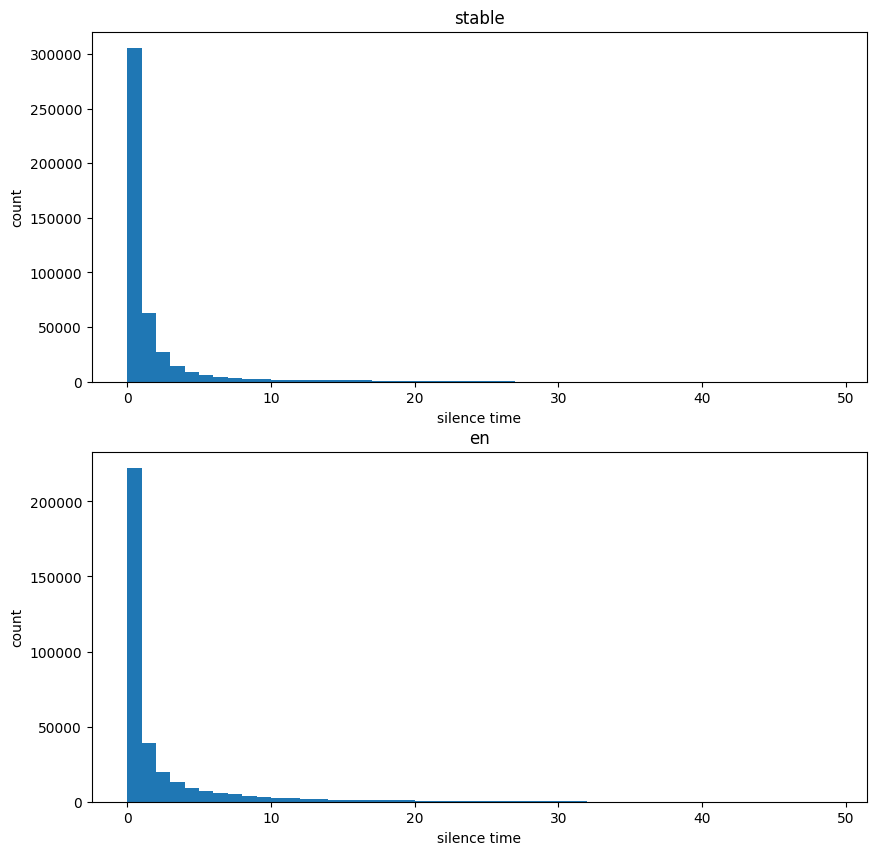

In [27]:
# 沈黙時間の分布を可視化
import matplotlib.pyplot as plt

plt.tight_layout()

def plot_silence(df: pd.DataFrame, ax: plt.Axes, title: str):
    df['prev_end'] = df['end'].shift(1)
    df['silence'] = (df['start'] - df['prev_end'])

    df.loc[df['silence'] < 0, 'silence'] = None
    df['silence'].hist(bins=range(0, 50), ax=ax)
    ax.set_title(title)
    ax.set_xlabel("silence time")
    ax.set_ylabel("count")
    ax.grid()


fig, ax = plt.subplots(2, 1, figsize=(10, 10))
plot_silence(span_df, ax[0], "stable")
plot_silence(span_en_df, ax[1], "en")


In [42]:
# 30秒以上の沈黙時間があるコメント数を算出
def add_over_30_sec_silence(df: pd.DataFrame):
    df['prev_end'] = df['end'].shift(1)
    df['silence'] = (df['start'] - df['prev_end'])

    df.loc[df['silence'] < 0, 'silence'] = None
    return df

def get_count_over_30_sec_silence(df: pd.DataFrame):
    df = add_over_30_sec_silence(df)
    return (df['silence'] > 30).sum()

def get_count_over_30_sec_silence_rate(df: pd.DataFrame):
    df = add_over_30_sec_silence(df)
    return (df['silence'] > 30).sum() / len(df)


print(f"{get_count_over_30_sec_silence(span_df)=}")
print(f"{get_count_over_30_sec_silence(span_en_df)=}")
print("--------")
print(f"{get_count_over_30_sec_silence_rate(span_df)=}")
print(f"{get_count_over_30_sec_silence_rate(span_en_df)=}")


get_count_over_30_sec_silence(span_df)=1424
get_count_over_30_sec_silence(span_en_df)=4589
--------
get_count_over_30_sec_silence_rate(span_df)=0.003109679532674565
get_count_over_30_sec_silence_rate(span_en_df)=0.012766265234530397


In [40]:
def head_over_30_sec_silence(df: pd.DataFrame):
    df = add_silence(df)
    return df.loc[df['silence'] > 30, ["start", "end", "text"]].head(20)



,start,end,text
309957,838.433,840.194,Панчон.
18231,329.486,330.188,There's Van Persie.
298765,2363.692,2365.615,Tigers pass just evading Wal Kraus.
311361,2136.446,2137.107,by Fabregas.
311415,2530.834,2547.499,corks in the game for Fernandez who may cruel...
420787,2258.263,2258.724,Morrison.
420884,250.601,264.669,in the right place to play with all the trans...
421001,1027.063,1028.666,Northorn's a much noisier place now.
92336,1660.925,1666.308,Scott down.
92464,2535.964,2536.064,Pedro.


In [37]:
def add_over_30_sec_start_gap(df: pd.DataFrame):
    df['prev_start'] = df['start'].shift(1)
    df['gap'] = (df['start'] - df['prev_start'])

    df.loc[df['gap'] < 0, 'gap'] = None
    return df

def get_count_over_30_sec_start_gap(df: pd.DataFrame):
    df = add_over_30_sec_start_gap(df)
    return (df['gap'] > 30).sum()

print(f"{get_count_over_30_sec_start_gap(span_df)=}")
print(f"{get_count_over_30_sec_start_gap(span_en_df)=}")

get_count_over_30_sec_start_gap(span_df)=2286
get_count_over_30_sec_start_gap(span_en_df)=5312


In [30]:
def add_duration(df: pd.DataFrame) -> float:
    df['duration'] = df['end'] - df['start']
    return df

def get_duration_avg(df: pd.DataFrame) -> float:
    df = add_duration(df)
    duration_avg = df['duration'].mean()
    return duration_avg

print(f"{get_duration_avg(span_df)=}")
print(f"{get_duration_avg(span_en_df)=}")

get_duration_avg(span_df)=3.5816392914794477
get_duration_avg(span_en_df)=3.2968306545684705


In [12]:
def get_text_length_avg(df: pd.DataFrame) -> float:
    df['text_length'] = df['text'].str.len()
    text_length_avg = df['text_length'].mean()
    return text_length_avg

print(f"{get_text_length_avg(span_df)=}")
print(f"{get_text_length_avg(span_en_df)=}")

get_text_length_avg(span_df)=55.3145427744718
get_text_length_avg(span_en_df)=56.83933812381247


In [19]:
def get_word_count_avg(df: pd.DataFrame) -> float:
    # tips: listなどのobjectはstrで操作できる
    # https://stackoverflow.com/questions/41340341/how-to-determine-the-length-of-lists-in-a-pandas-dataframe-column
    df['word_count'] = df['text'].str.split().str.len()
    word_count_avg = df['word_count'].mean()
    return word_count_avg

print(f"{get_word_count_avg(span_df)=}")
print(f"{get_word_count_avg(span_en_df)=}")

get_word_count_avg(span_df)=9.604162253644155
get_word_count_avg(span_en_df)=10.415105309864993


In [13]:
def get_count_by_game_avg(df: pd.DataFrame) -> pd.DataFrame:
    count_df = df.groupby('game').size().reset_index(name='count')
    count_mean = count_df['count'].mean()
    return count_mean

print(f"{get_count_by_game_avg(span_df)=}")
print(f"{get_count_by_game_avg(span_en_df)=}")

get_count_by_game_avg(span_df)=978.4722222222222
get_count_by_game_avg(span_en_df)=768.0833333333334


In [91]:
def get_max_diff_game(df_grouped: pd.DataFrame, df_en_grouped: pd.DataFrame) -> str:
    # コメント数の差が最大となるgameを選ぶ
    diff = (df_grouped['count'] - df_en_grouped['count'])
    max_diff_game = df_grouped.loc[diff.idxmax(), 'game']

    return max_diff_game

# gameごとのコメント数の差を可視化
def get_diff_comment_count(df: pd.DataFrame, df_en: pd.DataFrame):
    df_grouped = df.groupby('game').size().reset_index(name='count')
    df_en_grouped = df_en.groupby('game').size().reset_index(name='count')

    diff = (df_grouped['count'] - df_en_grouped['count'])
    diff.index = df_grouped['game']
    return diff

def show_max_diff_game(df: pd.DataFrame, df_en: pd.DataFrame):
    df_grouped = df.groupby('game').size().reset_index(name='count')
    df_en_grouped = df_en.groupby('game').size().reset_index(name='count')

    diff = get_diff_comment_count(df, df_en)

    max_diff_game = get_max_diff_game(df_grouped, df_en_grouped)
    max_diff = diff.loc[max_diff_game]
    print(f"{max_diff_game=}")
    print(f"{max_diff=}")
    print("--------")
    print(f"{df_grouped[df_grouped['game'] == max_diff_game]}")
    print(f"{df_en_grouped[df_en_grouped['game'] == max_diff_game]}")
    print("--------")
    print(f"{df.loc[df['game'] == max_diff_game, ['start', 'end', 'text']].sort_values(['start']).head(30)}")
    print("--------")
    print(f"{df_en.loc[df_en['game'] == max_diff_game, ['start', 'end', 'text']].sort_values(['start']).head(30)}")
show_max_diff_game(span_df, span_en_df)

max_diff_game='italy_serie-a/2016-2017/2016-10-29 - 21-45 Juventus 2 - 1 Napoli'
max_diff=1555
--------
                                                  game  count
298  italy_serie-a/2016-2017/2016-10-29 - 21-45 Juv...   1772
                                                  game  count
298  italy_serie-a/2016-2017/2016-10-29 - 21-45 Juv...    217
--------
        start     end                                               text
56918   0.169   4.352   И только что показали крупным планом Влада Ки...
56075   0.650   5.518   Сегодня играет третий Джорджо Келлини, 19-й Л...
56919   4.412   4.992                                           Он спас.
56920   5.012   7.954  Тогда в перерыве удалось посмотреть несколько ...
56076   5.538   7.682              Традиционная тройка в обороне фланги.
56077   7.742  13.332  Слева бразилец Александро под номером 12, спра...
56921   8.094   9.916                      До Пеппи Рейна дело не дошло.
56922  10.476  12.318                        Выбил мяч 

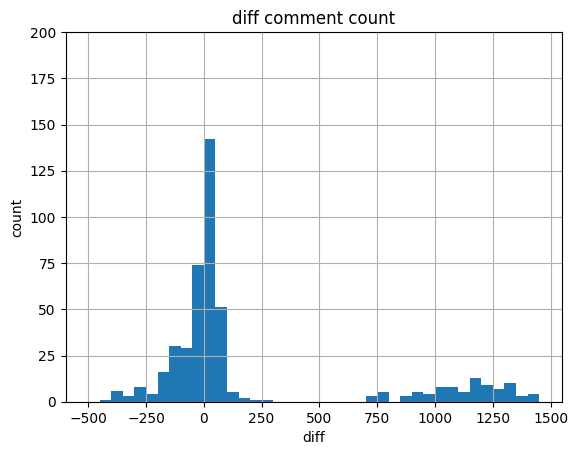

In [104]:
# 探索的データ分析 -プロット-
def get_games_extreme_diff(df: pd.DataFrame, df_en: pd.DataFrame) -> list:
    diff = get_diff_comment_count(df, df_en)
    over_games = diff[(diff > 500) | (diff < -500)].index.to_list()
    return over_games

def plot_diff_comment_count(df: pd.DataFrame, df_en: pd.DataFrame):
    diff = get_diff_comment_count(df, df_en)
    plt.hist(diff, bins=range(-500, 1500, 50))
    plt.ylim(0, 200)
    plt.title("diff comment count")
    plt.xlabel("diff")
    plt.ylabel("count")
    plt.grid()
    plt.show()

plot_diff_comment_count(span_df, span_en_df)
extreme_games = get_games_extreme_diff(span_df, span_en_df)

In [113]:
# 仮説：沈黙時間などの統計量の異常な差は、span_enのうち異常にコメント数が少ないgameに起因する
# 仮説検証
# 異常なコメント数の差があるgameを除いたデータを作成
total_game = set(span_df['game']) & set(span_en_df['game'])
print(f"{len(total_game)=}")
print(f"{len(extreme_games)=}")

span_df_cleaned = span_df[~(span_df['game'].isin(extreme_games))]
span_en_df_cleaned = span_en_df[~(span_en_df['game'].isin(extreme_games))]

# 算出
print(f"{get_silence_info(span_df_cleaned)=}")
print(f"{get_silence_info(span_en_df_cleaned)=}")
print("--------")
print(f"{get_count_over_30_sec_silence(span_df_cleaned)=}")
print(f"{get_count_over_30_sec_silence(span_en_df_cleaned)=}")
print("--------")
print(f"{get_count_over_30_sec_silence_rate(span_df_cleaned)=}")
print(f"{get_count_over_30_sec_silence_rate(span_en_df_cleaned)=}")
print("--------")
print(f"{get_count_over_30_sec_start_gap(span_df_cleaned)=}")
print(f"{get_count_over_30_sec_start_gap(span_en_df_cleaned)=}")

# 結果、ほとんど一緒になった
# つまり、仮説は正しい

len(total_game)=468
len(extreme_games)=95
get_silence_info(span_df_cleaned)={'silence_mean': 2.0476893767692492, 'inverse_rate': 0.0023428702885302274}
get_silence_info(span_en_df_cleaned)={'silence_mean': 2.2382705562308955, 'inverse_rate': 0.00220799293442261}
--------
get_count_over_30_sec_silence(span_df_cleaned)=1307
get_count_over_30_sec_silence(span_en_df_cleaned)=1345
--------
get_count_over_30_sec_silence_rate(span_df_cleaned)=0.003956242205567192
get_count_over_30_sec_silence_rate(span_en_df_cleaned)=0.003959667329064547
--------
get_count_over_30_sec_start_gap(span_df_cleaned)=2057
get_count_over_30_sec_start_gap(span_en_df_cleaned)=2070


/var/folders/8y/94zytg1j1h339lyf_x2r_ptr0000gn/T/ipykernel_26569/3494505697.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev_end'] = df['end'].shift(1)
/var/folders/8y/94zytg1j1h339lyf_x2r_ptr0000gn/T/ipykernel_26569/3494505697.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['silence'] = (df['start'] - df['prev_end'])
/var/folders/8y/94zytg1j1h339lyf_x2r_ptr0000gn/T/ipykernel_26569/230179459.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [119]:
# 仮説：ロシア語実況のgame と extreme_game は一致しているのでは
# 仮説検証
import json

from SoccerNet.Downloader import getListGames

from sn_script.config import Config

russian_path = Config.target_base_dir / "textfiles" / "russian_games.txt"

if not russian_path.exists():

    base_dir = Config.base_dir

    suffix = "_stable_version2"
    json_basename = "1_224p" + suffix + ".json"
    russian_games = []
    for game in getListGames("all"):
        json_path = base_dir / str(game) / json_basename
        if json_path.exists():
            data = json.load(open(json_path))
            if data['language'] == "ru":
                russian_games.append(game)

    print(f"{len(russian_games)=}")
    print(*russian_games, sep="\n")

    with open(russian_path, "w") as f:
        f.write("\n".join(russian_games))
else:
    with open(russian_path) as f:
        russian_games = f.read().splitlines()

print(f"{len(russian_games)=}")
print(f"{len(extreme_games)=}")
print(f"{len(set(russian_games) & set(extreme_games))=}")

# 結果、ロシア語実況のgame と extreme_game は一致している
# len(russian_games)=94
# len(extreme_games)=95
# len(set(russian_games) & set(extreme_games))=94
# つまり、仮説は正しい
# さらにいうと、ロシア語のtranslateはうまくいかないことがわかった

len(russian_games)=94
len(extreme_games)=95
len(set(russian_games) & set(extreme_games))=94


In [130]:
set(extreme_games) ^ set(russian_games)

{'italy_serie-a/2015-2016/2015-11-22 - 22-45 Inter 4 - 0 Frosinone'}

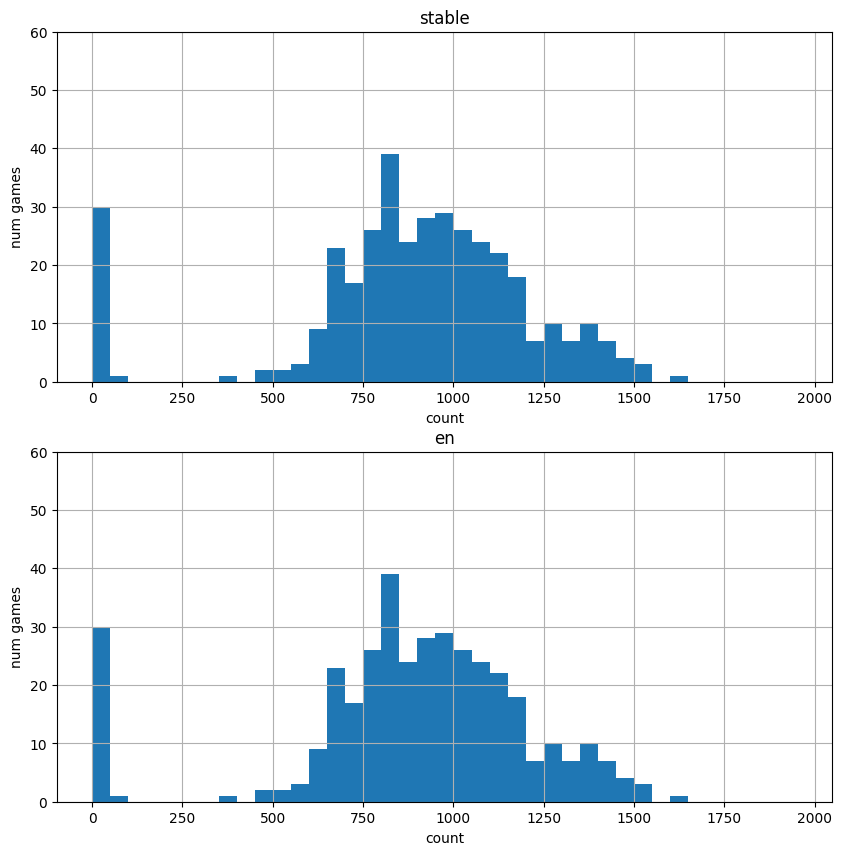

In [105]:
# 探索的データ分析 -プロット-
def get_grouped_by_game(df: pd.DataFrame) -> pd.DataFrame:
    return df.groupby('game').size().reset_index(name='count')

def plot_count_comments_per_game(df: pd.DataFrame, ax: plt.Axes, title: str):
    df_grouped = get_grouped_by_game(df)
    ax.hist(df_grouped['count'], bins=range(0, 2000, 50))
    ax.set_ylim(0, 60)
    ax.set_title(title)
    ax.set_xlabel("count")
    ax.set_ylabel("num games")
    ax.grid()

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
plot_count_comments_per_game(span_df_cleaned, ax[0], "stable")
plot_count_comments_per_game(span_df_cleaned, ax[1], "en")

In [117]:
def get_games_few_comments(df: pd.DataFrame, threshold: int) -> list:
    df_grouped = get_grouped_by_game(df)
    return df_grouped[df_grouped['count'] < threshold]['game'].to_list()

cand_games_span = get_games_few_comments(span_df, 500)
cand_games_span_en = get_games_few_comments(span_en_df, 500)

fewcomment_games = set(cand_games_span) & set(cand_games_span_en)


print(f"{len(total_game)=}")
print(f"{len(fewcomment_games)=}")


span_df_cleaned_more = span_df_cleaned[~(span_df_cleaned['game'].isin(fewcomment_games))]
span_en_df_cleaned_more = span_en_df_cleaned[~(span_en_df_cleaned['game'].isin(fewcomment_games))]

# 算出
print(f"{get_silence_info(span_df_cleaned_more)=}")
print(f"{get_silence_info(span_en_df_cleaned_more)=}")
print("--------")
print(f"{get_count_over_30_sec_silence(span_df_cleaned_more)=}")
print(f"{get_count_over_30_sec_silence(span_en_df_cleaned_more)=}")
print("--------")
print(f"{get_count_over_30_sec_silence_rate(span_df_cleaned_more)=}")
print(f"{get_count_over_30_sec_silence_rate(span_en_df_cleaned_more)=}")
print("--------")
print(f"{get_count_over_30_sec_start_gap(span_df_cleaned_more)=}")
print(f"{get_count_over_30_sec_start_gap(span_en_df_cleaned_more)=}")


len(total_game)=468
len(fewcomment_games)=34
get_silence_info(span_df_cleaned_more)={'silence_mean': 1.9472382577039515, 'inverse_rate': 0.0021782913190831706}
get_silence_info(span_en_df_cleaned_more)={'silence_mean': 2.139388744460419, 'inverse_rate': 0.0020382504770216103}
--------
get_count_over_30_sec_silence(span_df_cleaned_more)=1130
get_count_over_30_sec_silence(span_en_df_cleaned_more)=1163
--------
get_count_over_30_sec_silence_rate(span_df_cleaned_more)=0.0034378061320726014
get_count_over_30_sec_silence_rate(span_en_df_cleaned_more)=0.003440472140458828
--------
get_count_over_30_sec_start_gap(span_df_cleaned_more)=1853
get_count_over_30_sec_start_gap(span_en_df_cleaned_more)=1862


/var/folders/8y/94zytg1j1h339lyf_x2r_ptr0000gn/T/ipykernel_26569/3494505697.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev_end'] = df['end'].shift(1)
/var/folders/8y/94zytg1j1h339lyf_x2r_ptr0000gn/T/ipykernel_26569/3494505697.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['silence'] = (df['start'] - df['prev_end'])
/var/folders/8y/94zytg1j1h339lyf_x2r_ptr0000gn/T/ipykernel_26569/230179459.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


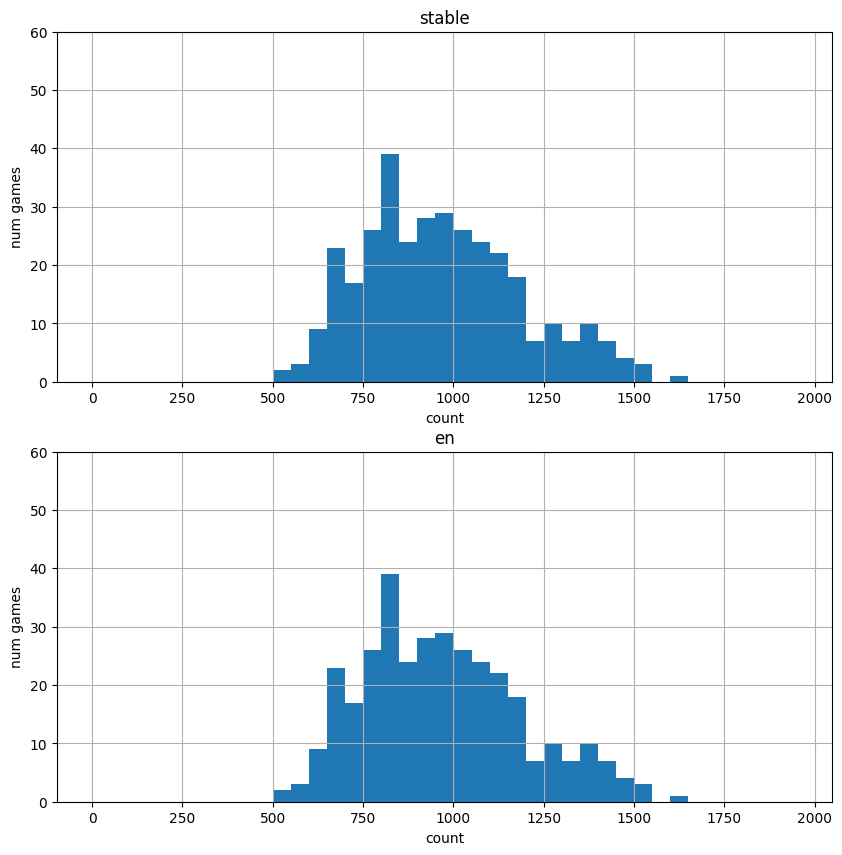

In [121]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))


plot_count_comments_per_game(span_df_cleaned_more, ax[0], "stable")
plot_count_comments_per_game(span_df_cleaned_more, ax[1], "en")

In [122]:
game_list = span_df_cleaned_more['game'].unique().tolist()
len(game_list)

339

In [ ]:
# 対象保存
extreme_games_txt = "database/textfiles/extreme_games.txt"
with open(extreme_games_txt, "w") as f:
    for game in extreme_games:
        f.write(f"{game}\n")

fewcomment_games_txt = "database/textfiles/fewcomment_games.txt"
with open(fewcomment_games_txt, "w") as f:
    for game in fewcomment_games:
        f.write(f"{game}\n")

In [5]:
# 保存する
import os
from collections.abc import Callable

import pandas as pd

from sn_script.config import binary_category_name, subcategory_name

denoised_stable_csv = "database/denoised/500game_stable_version2.csv"
denoised_stable_en_csv = "database/denoised/500game_stable_en.csv"

def drop_unnecessary(df: pd.DataFrame) -> pd.DataFrame:
    necessary_columns = ["id", "game", "half", "start", "end", "text"]
    return df[necessary_columns]

def strip_text(df: pd.DataFrame) -> pd.DataFrame:
    df['text'] = df['text'].str.strip()
    return df

def add_columns_for_label(df: pd.DataFrame) -> pd.DataFrame:
    df.loc[:, binary_category_name] = None
    df.loc[:, subcategory_name] = None
    df.loc[:, "備考"] = None
    return df

def sort_appropriate(df: pd.DataFrame) -> pd.DataFrame:
    df = df.sort_values(by=['game', 'half', 'start'])
    return df

def reset_index_and_drop(df: pd.DataFrame) -> pd.DataFrame:
    df = df.reset_index(drop=True)
    df["id"] = df.index
    return df

def preprocess_dataframe(
    df: pd.DataFrame,
    callbacks: list[Callable[[pd.DataFrame], pd.DataFrame]]
) -> pd.DataFrame:
    for callback in callbacks:
        df = callback(df)
    return df

callbacks = [
    drop_unnecessary,
    strip_text,
    add_columns_for_label,
    sort_appropriate,
    reset_index_and_drop
]

if os.path.exists(denoised_stable_csv):
    span_df_cleaned_more = pd.read_csv(denoised_stable_csv)
if os.path.exists(denoised_stable_en_csv):
    span_en_df_cleaned_more = pd.read_csv(denoised_stable_en_csv)

preprocess_dataframe(span_df_cleaned_more, callbacks).to_csv(denoised_stable_csv, index=False)
preprocess_dataframe(span_en_df_cleaned_more, callbacks).to_csv(denoised_stable_en_csv, index=False)

/var/folders/8y/94zytg1j1h339lyf_x2r_ptr0000gn/T/ipykernel_80394/1210138682.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].str.strip()
/var/folders/8y/94zytg1j1h339lyf_x2r_ptr0000gn/T/ipykernel_80394/1210138682.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[binary_category_name] = None
/var/folders/8y/94zytg1j1h339lyf_x2r_ptr0000gn/T/ipykernel_80394/1210138682.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/